# CottonWeed15 - MobileNetV3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        print("Running Deterministically")
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed, True)

2024-05-31 01:00:04.237598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 01:00:04.237719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 01:00:04.366925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Running Deterministically


In [2]:
# ! pip install kagglehub --upgrade --q

# import kagglehub
# print(kagglehub.__version__)

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret("kaggle_token")

# kagglehub.auth.set_kaggle_credentials('reganmaharjan',key)

In [3]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [4]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/cottonweed15-downsampled/labels.csv") ## For Kaggle
data_info = data_info[['img', 'label']]
data_info

,img,label
0,351b9a52aaaf40f592557cca89a902a5__nutsedge__0.jpg,Nutsedge
1,992b7dca6928459e85aafbf945585dd0__nutsedge__7.jpg,Nutsedge
2,8803be5e86774ff1b7116d5f5a5b2727__nutsedge__0.jpg,Nutsedge
3,e1da7a5e314a41c5886b384bd69320fc__nutsedge__0.jpg,Nutsedge
4,IMG_0547.JPG,Nutsedge
...,...,...
5182,1f101adc29984ee783d36d96ad6e5b7d__purselane__2...,Purslane
5183,0001.jpg,Purslane
5184,IMG_1426.JPG,Purslane
5185,IMG_1481 (3).JPG,Purslane


In [5]:
label_counts = data_info.groupby('label').count()
label_counts.T

label,Carpetweeds,Crabgrass,Eclipta,Goosegrass,Morningglory,Nutsedge,PalmerAmaranth,Prickly Sida,Purslane,Ragweed,Sicklepod,SpottedSpurge,SpurredAnoda,Swinecress,Waterhemp
img,763,111,254,216,1115,273,689,129,450,129,240,234,61,72,451


In [6]:
# label2id = data_info['label'].unique()
# label2id = {label2id[i]:i for i in range(len(label2id))}
# id2label = {label2id[i]:i for i in label2id}
label2id = {'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3,
            'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7,
            'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11,
            'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
id2label = {label2id[i]:i for i in label2id}
class_names = [id2label[i] for i in range(len(label2id))]

print(id2label)
print(label2id)
print(class_names)

{0: 'Nutsedge', 1: 'Sicklepod', 2: 'Morningglory', 3: 'Ragweed', 4: 'PalmerAmaranth', 5: 'Waterhemp', 6: 'Crabgrass', 7: 'Swinecress', 8: 'Prickly Sida', 9: 'Carpetweeds', 10: 'SpottedSpurge', 11: 'SpurredAnoda', 12: 'Eclipta', 13: 'Goosegrass', 14: 'Purslane'}
{'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3, 'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7, 'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11, 'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
['Nutsedge', 'Sicklepod', 'Morningglory', 'Ragweed', 'PalmerAmaranth', 'Waterhemp', 'Crabgrass', 'Swinecress', 'Prickly Sida', 'Carpetweeds', 'SpottedSpurge', 'SpurredAnoda', 'Eclipta', 'Goosegrass', 'Purslane']


In [7]:
data_info['img'] = data_info.apply(lambda x: str(label2id[x['label']])+"_"+x['img'], axis=1)
data_info['id'] = data_info.apply(lambda x: label2id[x['label']], axis=1)

In [8]:
threshold = label_counts.quantile(0.25).iloc[0]
print(threshold)

low_data_labels = label_counts[label_counts['img'] <= threshold] ## labels with very low data
print(low_data_labels.T)
low_data_labels = list(low_data_labels.T.keys())
low_data_labels

129.0
label  Crabgrass  Prickly Sida  Ragweed  SpurredAnoda  Swinecress
img          111           129      129            61          72


['Crabgrass', 'Prickly Sida', 'Ragweed', 'SpurredAnoda', 'Swinecress']

# Splitting Data into Train:Valid:Test Splits (60:40:40)

In [9]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 0 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

skfold = StratifiedKFold(shuffle=True, random_state=seed)
kSplits = skfold.split(data_info['img'], y=data_info['label'])

for index in range(skfold.get_n_splits()):
    train_index, test_index = next(kSplits)
    if index == split_index:
        break

Using KFold: Index 1 out of 5 folds
-------------------------------------------------



In [10]:
train_data = data_info.iloc[train_index]
test_data = data_info.iloc[test_index]

print("Is There Duplicates: ", not test_data[test_data['img'].isin(train_data['img'])].empty)
print("Train Data\n-----------------------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("||\nTest Data\n-------------------------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
-----------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            610         89      203         173           892       218   
id             610         89      203         173           892       218   

label  PalmerAmaranth  Prickly Sida  Purslane  Ragweed  Sicklepod  \
img               551           103       360      103        192   
id                551           103       360      103        192   

label  SpottedSpurge  SpurredAnoda  Swinecress  Waterhemp  
img              187            49          58        361  
id               187            49          58        361   	Total: (4149, 3)
||
Test Data
-------------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            153         22       51          43           223        55   
id             153         22       51          43           223        55   

label  PalmerAmarant

# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [11]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['img']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]

    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=80, #'vertical',
        # ax = ax
    )
    # fig, ax = plt.subplots(figsize=(25,5))
    # cmd.plot(ax=ax)
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [13]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/cottonweed15-downsampled/img" ## For Kaggle
base_dir = "/kaggle/working/cottonweed15" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
train_generator, test_generator = getDatasetGenerators(
      train_dir,
      batch_size=12,
      label_mode='categorical',
      class_names=class_names,
      image_size = IMG_SIZE[:2],
      shuffle=True,
      seed=seed,
      validation_split=0.2,
      subset="both"
)

validation_generator = getDatasetGenerators(
      test_dir,
      batch_size=12,
      shuffle=True,
      label_mode='categorical',
      class_names=class_names,
      image_size = IMG_SIZE[:2],
)

Found 4149 files belonging to 15 classes.
Using 3320 files for training.
Using 829 files for validation.
Found 1038 files belonging to 15 classes.


In [15]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

# Sample Images

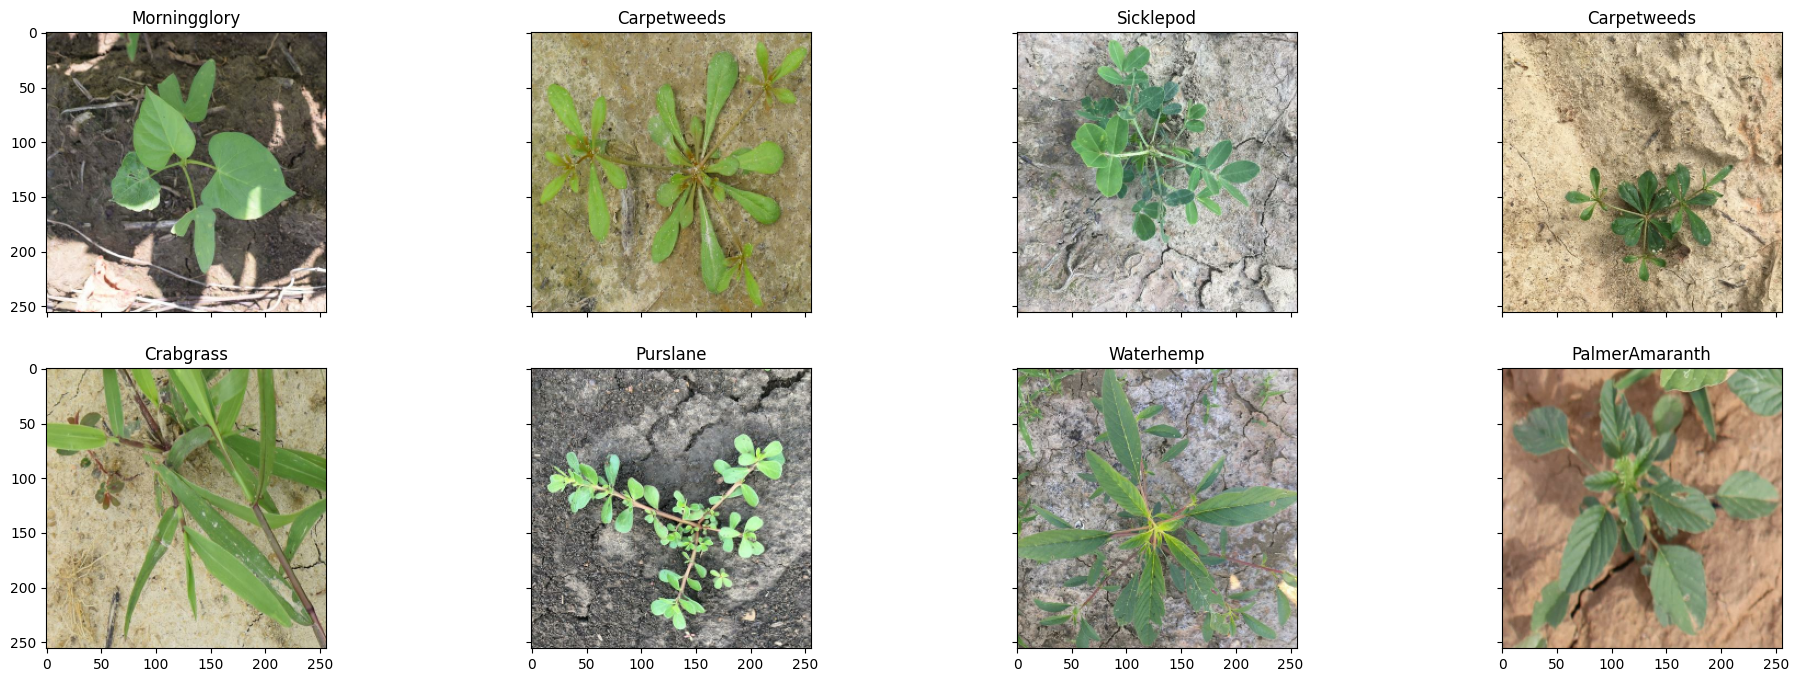

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# Pooling Schemes

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class SpatialMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialMaxPooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class SpatialAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialAveragePooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def AverageOfMaximums(x, max_pool_size=2, keepdims=False, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(keepdims = keepdims, name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

# Spatial Attention
> from CBAM

In [18]:
def spatial_attention(input_feature):
    kernel_size = 5

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1

    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [19]:
def MultiKernelSpatialAttention(input_feature, kernels=[1,3,5,7], layer_num=0):
    in_size = input_feature.shape[1]

    channel = input_feature.shape[-1]
    x = input_feature

    pool_size = channel // 8
    
    channel_avg = SpatialAveragePooling2D(pool_size, padding='same')(x)
    channel_max = SpatialMaxPooling2D(pool_size, padding='same')(x)
    
    concat = layers.Concatenate(axis=3)([channel_avg, channel_max])
    
    attentions = []

    for kernel in kernels:
        attentions.append(
            layers.Conv2D(filters = 1,
                kernel_size=kernel,
                strides=1,
                padding='same',
                activation='sigmoid',
                kernel_initializer='he_normal',
                use_bias=False)(concat)
            )
      
    attentions = layers.Average()(attentions)

    x =  layers.Multiply()([input_feature, attentions])
    return x

# Transformer Encoder: Global Self Attention & Point-wise Feed Forward

In [20]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# Building MobileNet Model

In [21]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet')
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet')
    mobilenet.trainable = True

    base_model =  keras.Model(inputs=mobilenet.layers[0].input, outputs=mobilenet.layers[-11].output, name = mobilenet.name+"_base_")
    base_model.trainable = True

    pooler = mobilenet.layers[-9]

    return base_model , pooler

def buildModel(IMG_SIZE):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base((224,224,3), use='S')
    base_model.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
    x = layers.Resizing(224, 224, name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)
    
    x = MultiKernelSpatialAttention(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(15, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [22]:
# IMG_SIZE = (256,256,3)
# seed = 42

model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 1s 0us/step
Base Model: MobilenetV3small_base_
229
Model: "CottonWeed15-MobilenetV3small_base_"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 PP_Rescale (Rescaling)      (None, 256, 256, 3)          0         ['input[0][0]']               
                                                                                                  
 PP_Resize (Resizing)        (None, 224, 224, 3)          0         ['PP_Rescale[0][0]']          
                                                                                                  
 augment_pipeline (Sequenti  (None, 224, 224, 3)          0

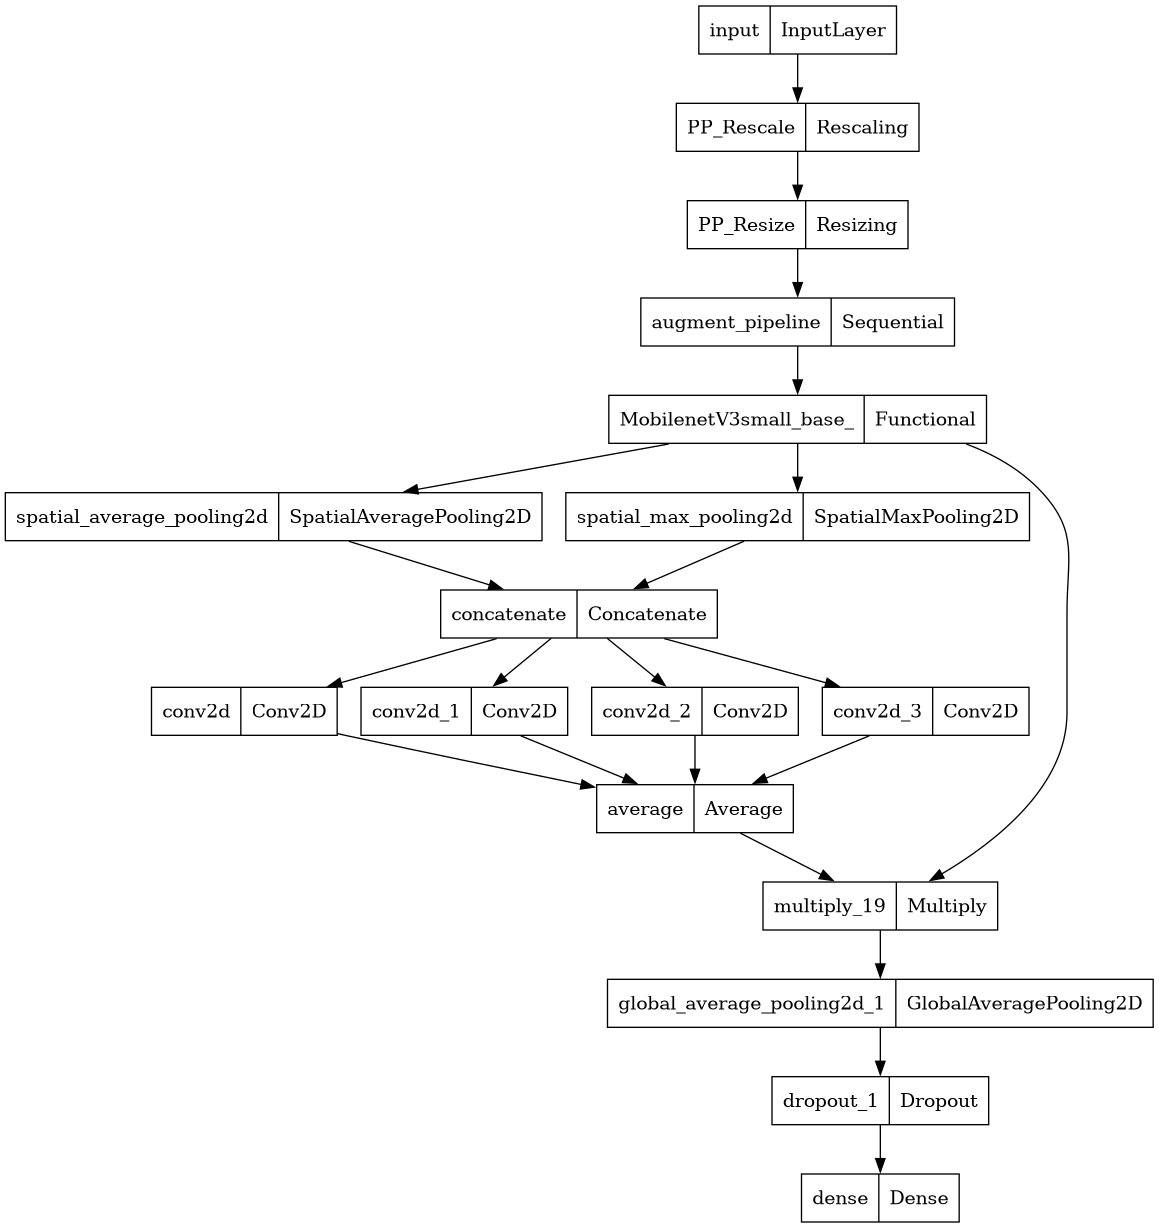

In [23]:
keras.utils.plot_model(model)

# Trial 1 - FineTuning

In [24]:
from tensorflow.keras.optimizers import Adam, AdamW

# Constant for epochs
EPOCHS = 100

pat_es = 15
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.75, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])

Epoch 1/100


I0000 00:00:1717117286.988481      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


277/277 [==============================] - 47s 56ms/step - loss: 2.0936 - accuracy: 0.3214 - val_loss: 1.3461 - val_accuracy: 0.5742 - lr: 2.0000e-04
Epoch 2/100
277/277 [==============================] - 15s 52ms/step - loss: 1.2890 - accuracy: 0.5916 - val_loss: 0.8993 - val_accuracy: 0.7254 - lr: 2.0000e-04
Epoch 3/100
277/277 [==============================] - 14s 51ms/step - loss: 0.9922 - accuracy: 0.6907 - val_loss: 0.6807 - val_accuracy: 0.7996 - lr: 2.0000e-04
Epoch 4/100
277/277 [==============================] - 14s 52ms/step - loss: 0.7840 - accuracy: 0.7500 - val_loss: 0.5677 - val_accuracy: 0.8179 - lr: 2.0000e-04
Epoch 5/100
277/277 [==============================] - 14s 50ms/step - loss: 0.7023 - accuracy: 0.7687 - val_loss: 0.5253 - val_accuracy: 0.8410 - lr: 2.0000e-04
Epoch 6/100
277/277 [==============================] - 14s 52ms/step - loss: 0.6548 - accuracy: 0.7892 - val_loss: 0.4706 - val_accuracy: 0.8536 - lr: 2.0000e-04
Epoch 7/100
277/277 [===================

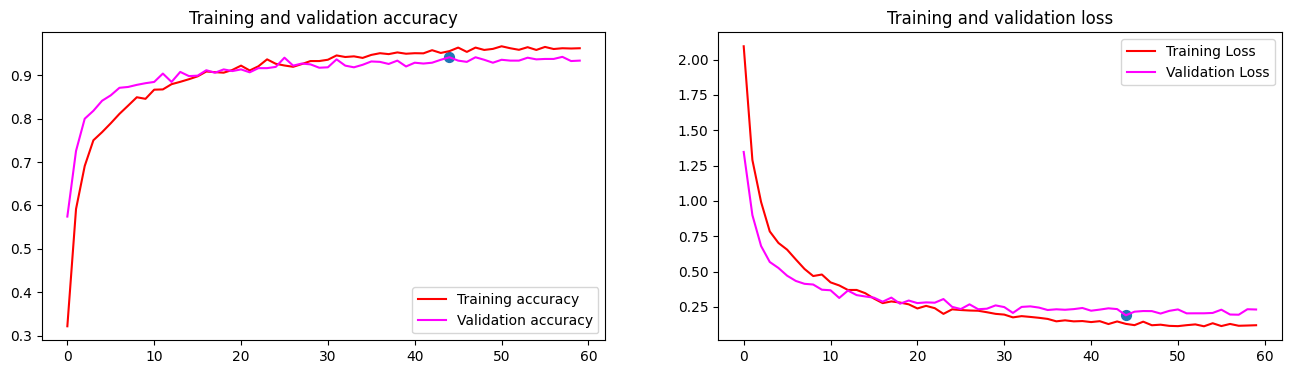

CPU times: user 28min 39s, sys: 1min 25s, total: 30min 5s
Wall time: 14min 52s


In [25]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
87/87 [==============================] - 1s 14ms/step - loss: 0.2235 - accuracy: 0.9316
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.96364   0.96364   0.96364        55
     Sicklepod    0.90196   0.95833   0.92929        48
  Morningglory    0.95111   0.95964   0.95536       223
       Ragweed    1.00000   0.96154   0.98039        26
PalmerAmaranth    0.93284   0.90580   0.91912       138
     Waterhemp    0.89583   0.95556   0.92473        90
     Crabgrass    0.91304   0.95455   0.93333        22
    Swinecress    1.00000   0.85714   0.92308        14
  Prickly Sida    0.86364   0.73077   0.79167        26
   Carpetweeds    0.95570   0.98693   0.97106       153
 SpottedSpurge    0.91837   0.95745   0.93750        47
  SpurredAnoda    0.78571   0.91667   0.84615        12
       Eclipta    0.86957   0.78431   0.82474        51
    Goosegrass    0.92857   0.90698   0.91765        43
      Purslane    0.97674   0.93333   0.95455        90

      accuracy                        0.93545      1038
     macro avg    0.92378 

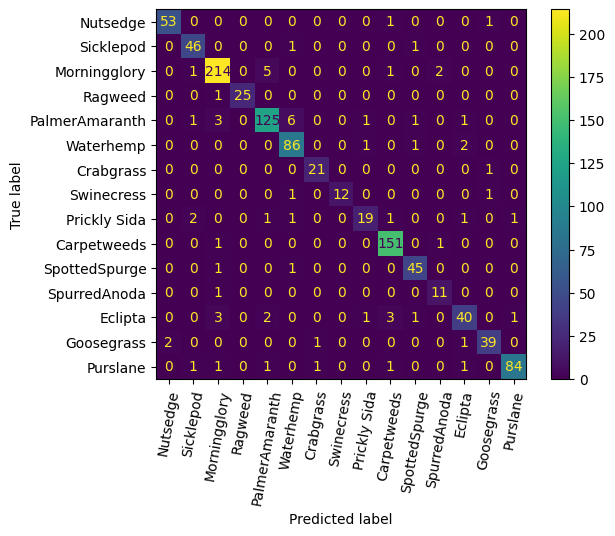

In [26]:
a, b = eval_model(model, validation_generator)

model.evaluate
70/70 [==============================] - 1s 16ms/step - loss: 0.1471 - accuracy: 0.9469
model.predict


  0%|          | 0/70 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.90698   0.97500   0.93976        40
     Sicklepod    0.93939   0.93939   0.93939        33
  Morningglory    0.98276   0.96610   0.97436       177
       Ragweed    0.95000   0.95000   0.95000        20
PalmerAmaranth    0.96262   0.95370   0.95814       108
     Waterhemp    0.88571   0.98413   0.93233        63
     Crabgrass    1.00000   0.88235   0.93750        17
    Swinecress    1.00000   1.00000   1.00000        11
  Prickly Sida    0.89474   0.85000   0.87179        20
   Carpetweeds    0.94656   0.93939   0.94297       132
 SpottedSpurge    0.90000   0.94737   0.92308        38
  SpurredAnoda    0.70000   0.87500   0.77778         8
       Eclipta    0.97778   0.93617   0.95652        47
    Goosegrass    0.93750   0.88235   0.90909        34
      Purslane    0.96203   0.93827   0.95000        81

      accuracy                        0.94692       829
     macro avg    0.92974 

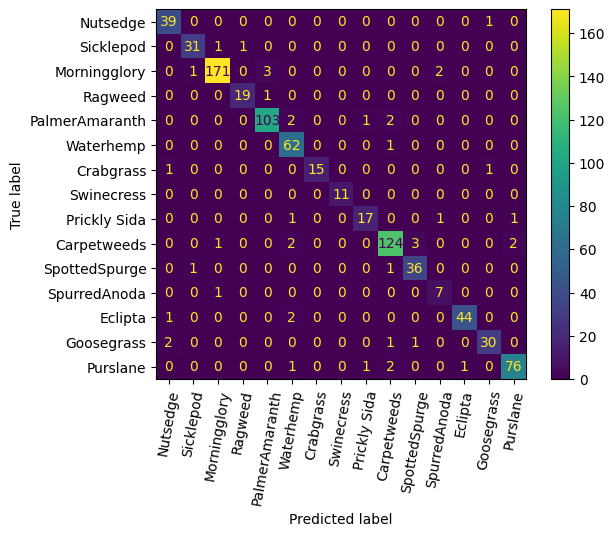

In [27]:
a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small_base_
Epoch 1/100
277/277 [==============================] - 13s 28ms/step - loss: 0.0798 - accuracy: 0.9750 - val_loss: 0.1725 - val_accuracy: 0.9576 - lr: 2.0000e-04
Epoch 2/100
277/277 [==============================] - 7s 24ms/step - loss: 0.0687 - accuracy: 0.9771 - val_loss: 0.1660 - val_accuracy: 0.9557 - lr: 2.0000e-04
Epoch 3/100
277/277 [==============================] - 7s 23ms/step - loss: 0.0631 - accuracy: 0.9789 - val_loss: 0.1694 - val_accuracy: 0.9566 - lr: 2.0000e-04
Epoch 4/100
277/277 [==============================] - 7s 24ms/step - loss: 0.0672 - accuracy: 0.9765 - val_loss: 0.1741 - val_accuracy: 0.9566 - lr: 2.0000e-04
Epoch 5/100
274/277 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9754
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
277/277 [==============================] - 7s 23ms/step - loss: 0.0807 - accuracy: 0.9756 - val_loss: 0.1691 - val_accuracy: 0.9576 - lr: 2.0000

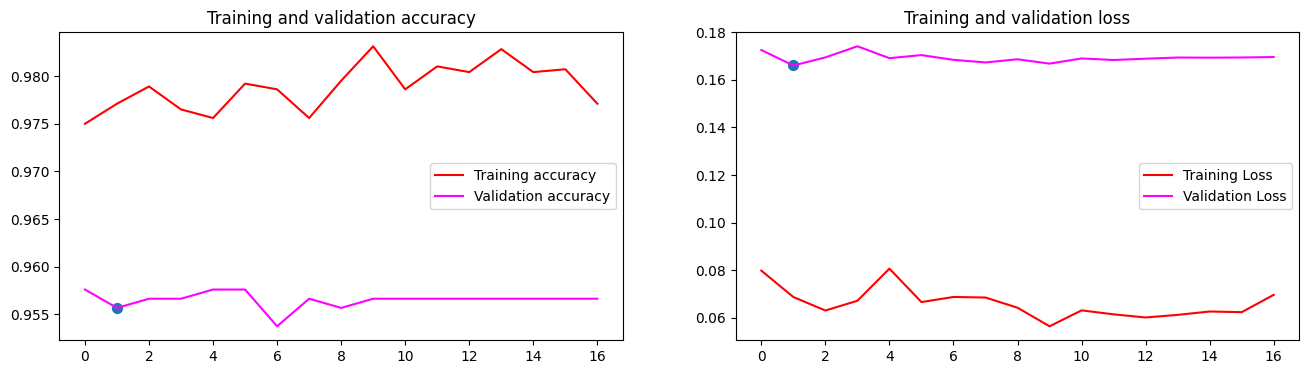

CPU times: user 5min 38s, sys: 16.6 s, total: 5min 55s
Wall time: 2min


In [28]:
%%time
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)
# model = skipAugment(model)
for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
    optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
    metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-8)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

# Evaluations

Total Epochs: range(0, 77)


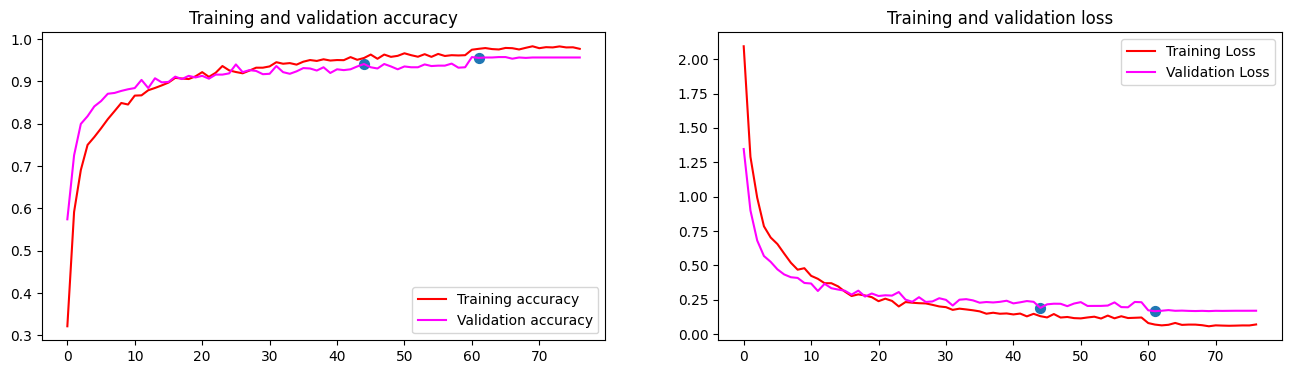

In [29]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 60)


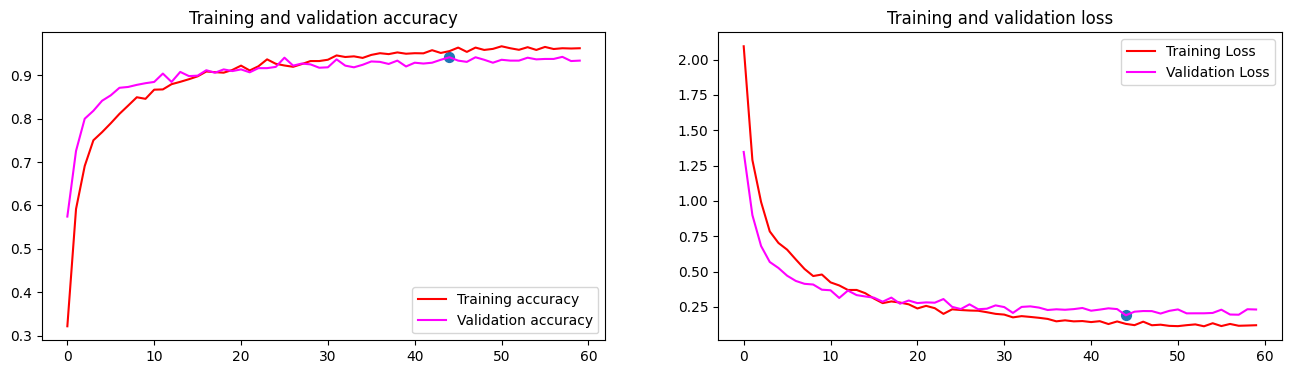

Total Epochs: range(0, 17)


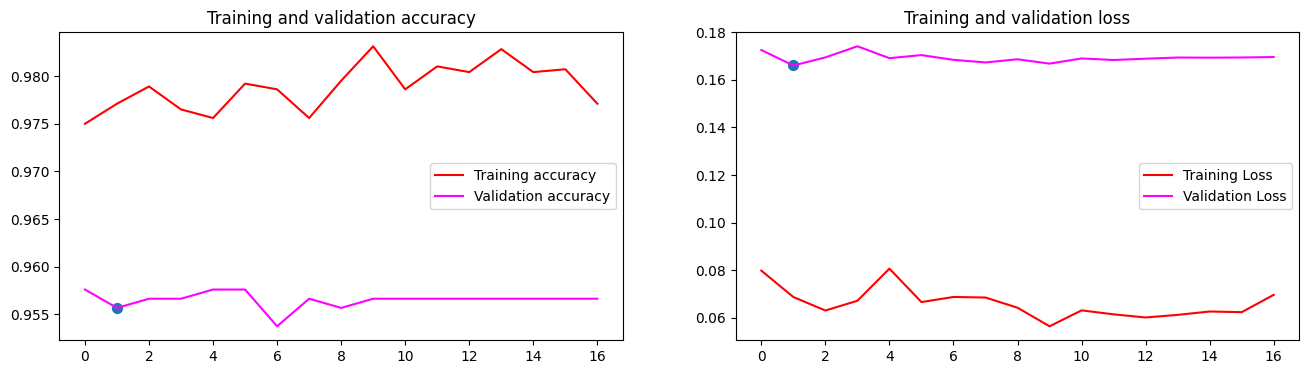

In [30]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

model.evaluate
87/87 [==============================] - 1s 14ms/step - loss: 0.1660 - accuracy: 0.9557
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.98148   0.96364   0.97248        55
     Sicklepod    0.92157   0.97917   0.94949        48
  Morningglory    0.96847   0.96413   0.96629       223
       Ragweed    1.00000   1.00000   1.00000        26
PalmerAmaranth    0.95683   0.96377   0.96029       138
     Waterhemp    0.94681   0.98889   0.96739        90
     Crabgrass    0.91304   0.95455   0.93333        22
    Swinecress    0.92857   0.92857   0.92857        14
  Prickly Sida    0.89474   0.65385   0.75556        26
   Carpetweeds    0.96178   0.98693   0.97419       153
 SpottedSpurge    0.95833   0.97872   0.96842        47
  SpurredAnoda    0.80000   1.00000   0.88889        12
       Eclipta    0.97619   0.80392   0.88172        51
    Goosegrass    0.93333   0.97674   0.95455        43
      Purslane    0.96629   0.95556   0.96089        90

      accuracy                        0.95568      1038
     macro avg    0.94050 

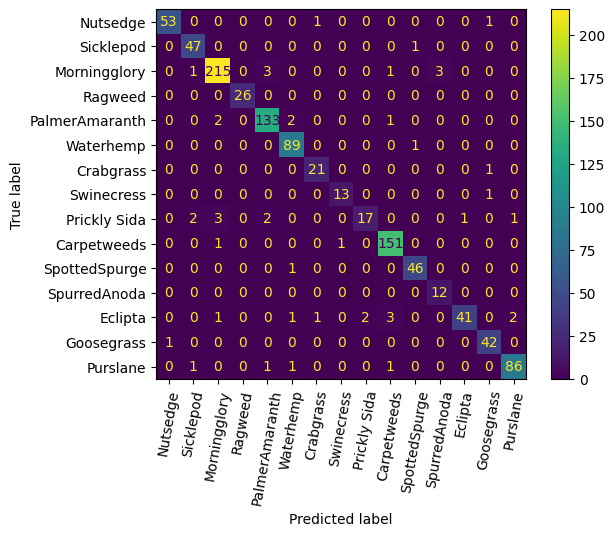

In [31]:
## Computing Positive Threshold Using Validation Dataset

a, b = eval_model(model,validation_generator)

# Test Set Evaluation

model.evaluate
70/70 [==============================] - 1s 14ms/step - loss: 0.1076 - accuracy: 0.9566
model.predict


  0%|          | 0/70 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.95122   0.97500   0.96296        40
     Sicklepod    1.00000   0.96970   0.98462        33
  Morningglory    0.98295   0.97740   0.98017       177
       Ragweed    1.00000   0.95000   0.97436        20
PalmerAmaranth    0.97170   0.95370   0.96262       108
     Waterhemp    0.93750   0.95238   0.94488        63
     Crabgrass    1.00000   0.94118   0.96970        17
    Swinecress    1.00000   1.00000   1.00000        11
  Prickly Sida    1.00000   0.70000   0.82353        20
   Carpetweeds    0.95455   0.95455   0.95455       132
 SpottedSpurge    0.97222   0.92105   0.94595        38
  SpurredAnoda    0.66667   1.00000   0.80000         8
       Eclipta    0.91837   0.95745   0.93750        47
    Goosegrass    1.00000   0.94118   0.96970        34
      Purslane    0.89888   0.98765   0.94118        81

      accuracy                        0.95657       829
     macro avg    0.95027 

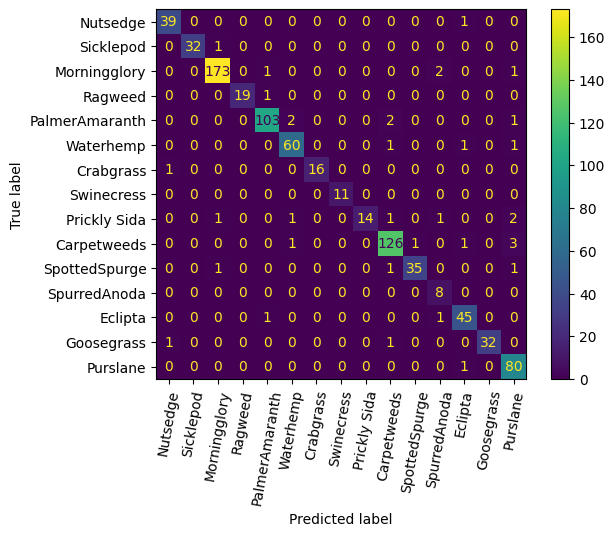

In [32]:
a, b = eval_model(model, test_generator)

In [33]:
shutil.rmtree(base_dir)